# St Helens dv/v - Rain&Snow Correction Cookbook


In [131]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
import datetime
import matplotlib
import glob
# matplotlib.use('nbagg')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6) 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy import signal
from scipy.special import erf, erfc
from scipy.interpolate import RegularGridInterpolator
# import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
# sns.set_style("whitegrid")
# sns.set_palette("bright")
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt
from obspy import UTCDateTime

## 00 Compare spatial resolutions of weather and dv/v

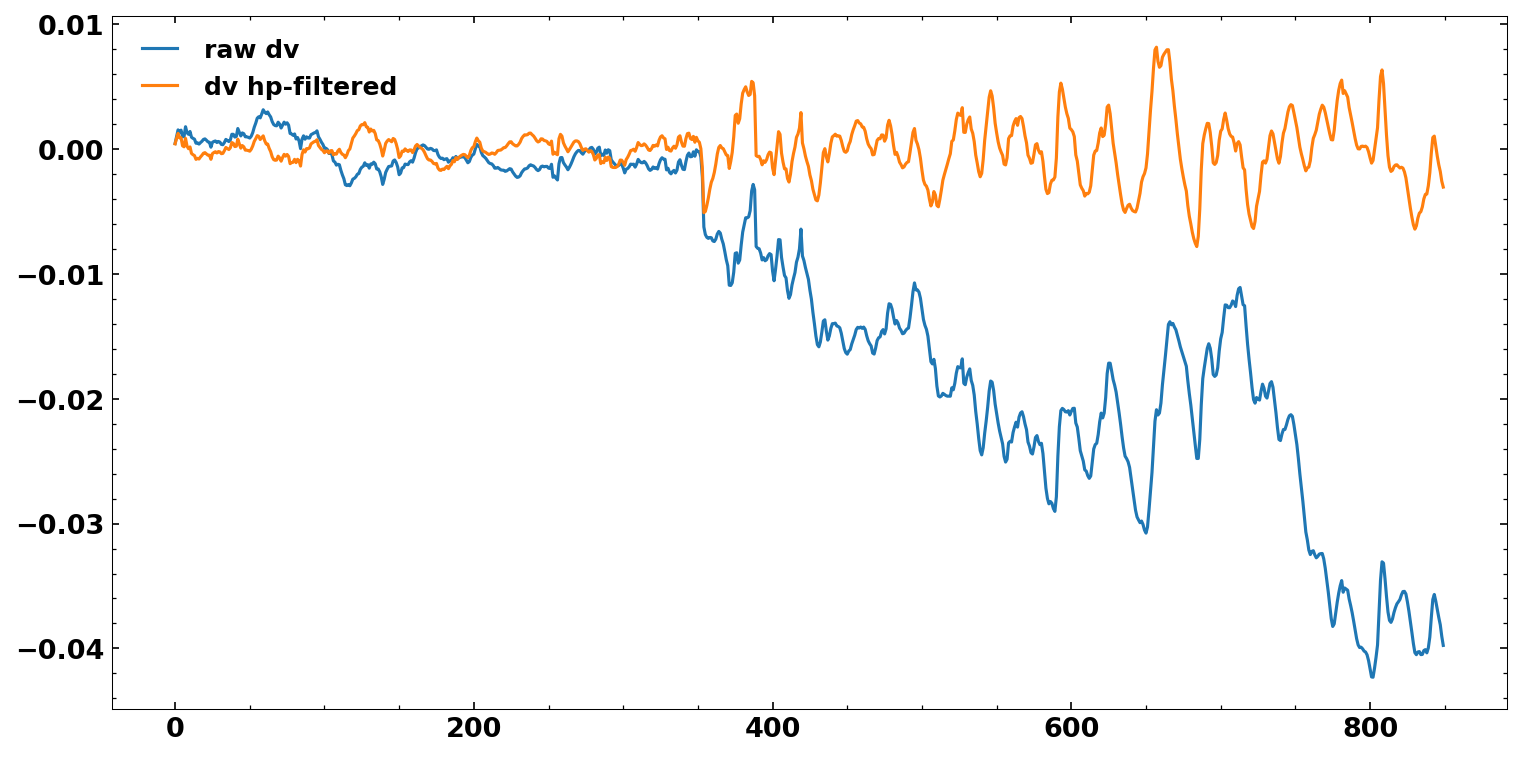

In [132]:
pluvio = pd.read_csv(
    "../climate data/larger_area/climate_MSH.csv", index_col=0, parse_dates=True)
lats = pluvio['latitude']
lons = pluvio['longitude']
pluvio['date'] = [datetime.datetime.strptime(dt, '%Y-%m-%d') for dt in pluvio['date']]
coords = np.array([np.array([lat, lon, UTCDateTime(d).timestamp]) for lat, lon, d in zip(lats, lons, pluvio['date'])])


freq = 0.5

infile = glob.glob(f'/home/pm/Documents_sync/PhD/StHelens/spatial/ddt_newdvs_cl1_std0.15_largemap/xstations_{freq}-{freq*2}_wl864000_*/dvdt_3D.npz')[0]

loaded = np.load(infile)

x = loaded['xaxis']
y = loaded['yaxis']
t = loaded['taxis']
dvdt = loaded['dv']
statx = loaded['statx']
staty = loaded['staty']
# No data anymore from this date on
start = 0  # 4 for february # Start here for February
end = 850
dv_nodt = np.nancumsum(dvdt[:, :, start:end], axis=-1)
# dvdt[~np.isnan(dvdt)] = detrend(dvdt[~np.isnan(dvdt)],  type='constant', bp=[0, 375])

# note I set the sampling interval in units of days
sos = signal.butter(4, 1/1200, 'highpass', fs=0.1, output='sos')
# w, h = signal.freqs(b, a)
dv = signal.sosfilt(sos, np.nancumsum(dvdt[:, :, start:end], axis=-1))


plt.plot(dv_nodt[5, 5, :], label='raw dv')
# remove the trend from the post-eruption period
plt.plot(dv[5, 5, :], label='dv hp-filtered')
plt.legend()

t = t[start:end]

# I guess it makes the most sense to downsample dv/v onto the coarser climate grid

dvlat = km2d(y)
lat0 = dvlat.min()
lon0 = -122.34
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
dvlon = km2lon*(x-x.min())+lon0

f = RegularGridInterpolator((dvlat, dvlon, t), dv, bounds_error=False, fill_value=np.nan)
dv_int = f(coords)
# pluvio['dv'] = pluvio['dv'].ffill()
pluvio['dv'] = -1*dv_int

In [133]:
vel = 2  # apparent surface wave velocity for depth sensitivity


# For testing purposes filter for only one coord
pluvio = pluvio[pluvio['latitude'] == 46.2]
pluvio = pluvio[np.isclose(pluvio['longitude'], -122.2)]
# assign new index
pluvio.index = np.arange(len(pluvio), dtype=int)


# #### changes by Peter ####
# create water influx as difference of melt and remaining snow
# note that snow has to be given in m water equivalent in precipitation in m
# meltwater[meltwater < 0] = 0
pluvio['water_influx'] = pluvio['total precipitation'] + pluvio['snowmelt'] - pluvio['snowfall']
# set to mm
pluvio["water_influx"] *= 1000

# ## original
# pluvio["water_influx"] = pluvio['total_precipitation']*1000

pluvio["rate"] = pluvio["water_influx"].ffill()

pluvio["load"] = 0.0
pluvio.loc[1:,"load"] = np.diff(pluvio["rate"]) * 9.81 * 1.0
pluvio

,snow depth,total precipitation,snowmelt,snowfall,date,latitude,longitude,dv,water_influx,rate,load
0,0.321027,0.002019,0.000000,0.001669,1993-01-01,46.2,-122.2,NaN,0.350318,0.350318,0.000000
1,0.321671,0.000187,0.000000,0.000124,1993-01-02,46.2,-122.2,NaN,0.062722,0.062722,-2.821318
2,0.322947,0.000962,0.000000,0.000201,1993-01-03,46.2,-122.2,NaN,0.761278,0.761278,6.852835
3,0.352102,0.015419,0.000000,0.010017,1993-01-04,46.2,-122.2,NaN,5.402854,5.402854,45.533863
4,0.356655,0.001759,0.000000,0.001400,1993-01-05,46.2,-122.2,NaN,0.359268,0.359268,-49.477579
...,...,...,...,...,...,...,...,...,...,...,...
10952,0.262859,0.027939,0.005412,0.000000,2022-12-27,46.2,-122.2,NaN,33.351128,33.351128,245.452454
10953,0.286556,0.015900,0.000296,0.014223,2022-12-28,46.2,-122.2,NaN,1.972261,1.972261,-307.826686
10954,0.291760,0.001439,0.000092,0.001059,2022-12-29,46.2,-122.2,NaN,0.472499,0.472499,-14.712664
10955,0.301303,0.012669,0.000674,0.003830,2022-12-30,46.2,-122.2,NaN,9.513777,9.513777,88.694934


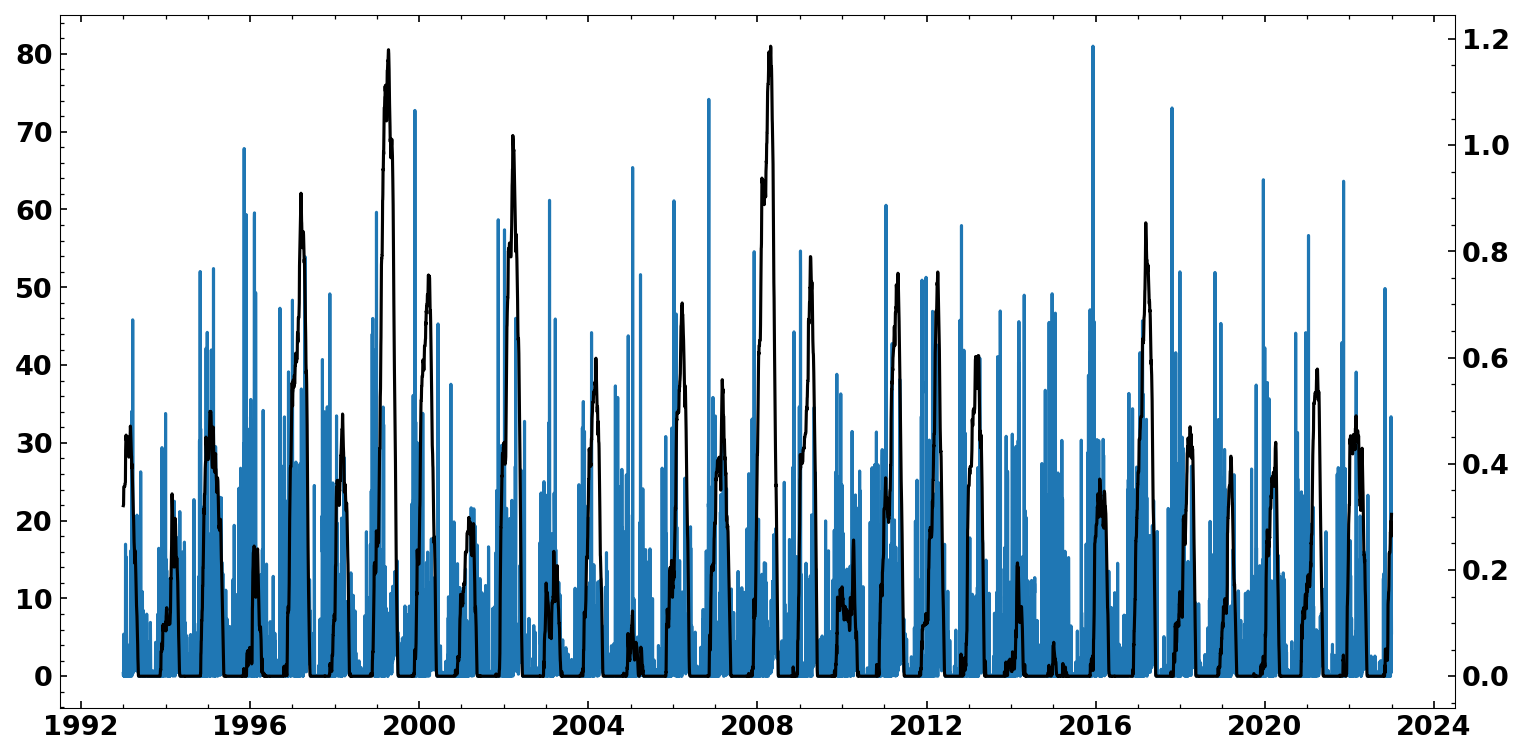

In [134]:
plt.plot(pluvio['date'], pluvio['water_influx'])
plt.twinx()
plt.plot(pluvio['date'], pluvio["snow depth"], 'k')
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())

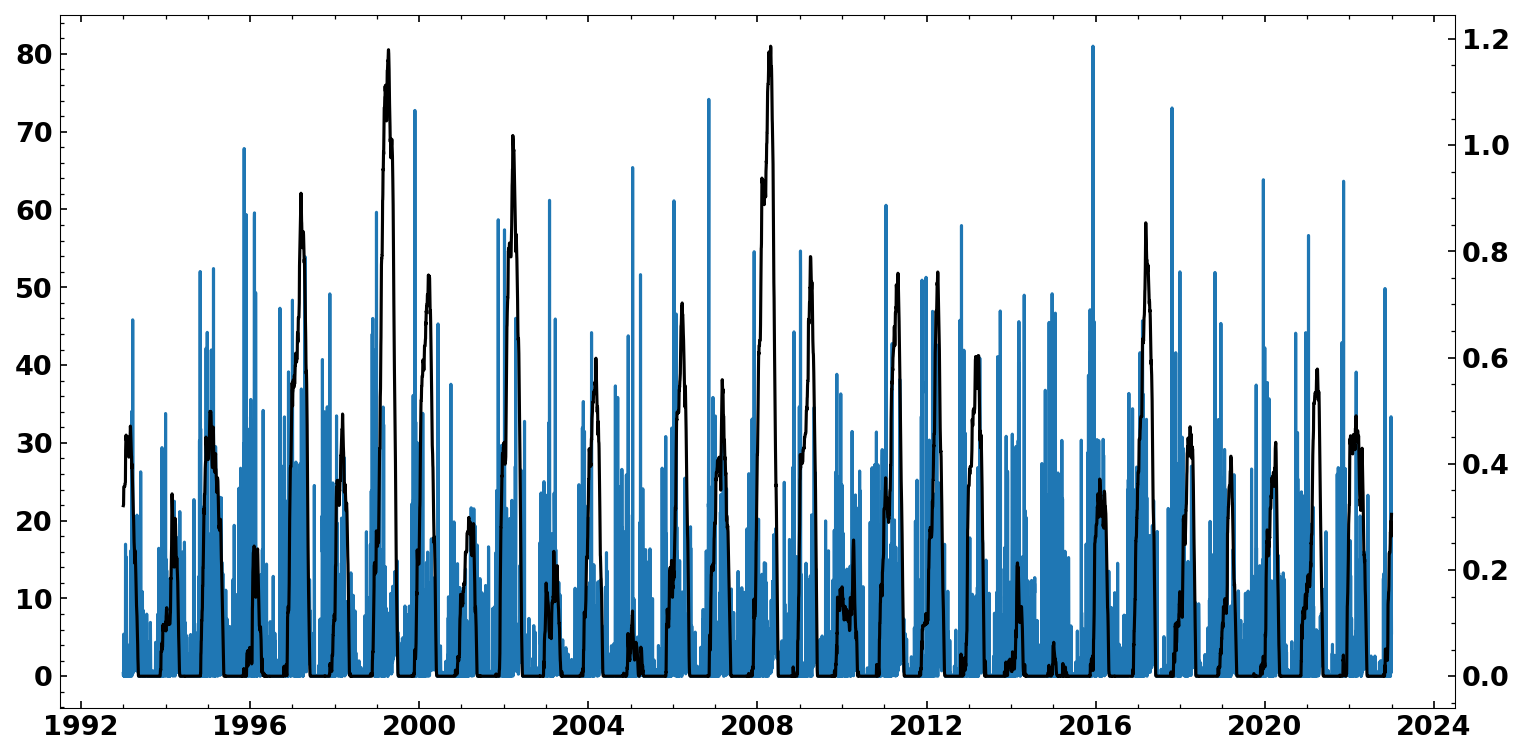

In [135]:
plt.plot(pluvio['date'], pluvio["rate"])
plt.twinx()
# pluvio["Snow depth (cm)"].plot(c='k')
plt.plot(pluvio['date'], pluvio["snow depth"], 'k')
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())

## Computing pore pressure change diffusion P(t,r)

The dmin parameter is defined as 1000 m manually, it is a subjective decision,
in the future it should probably be optimised automatically too.

The final P(t) is the linear average of P(t,r).

In [136]:

c = .3 #1.0  # diffusivity
c2 = .1  # Is there a diffusitivity change after eruption?
alpha1 = c
alpha2 = c2
dt = 86400.0


dmin = 1000
dmax = 4000
dstep = 500

# change dmin dmax depending on frequency?
# for 1 Hz
# wavelen = vel/freq
# dmin = wavelen/20
# dmax = 2*wavelen/3
# dstep = (dmax-dmin)/10

depths = np.arange(dmin, dmax+dstep, dstep)
pluvio["P"] = 0.0
pluvio["Pdiff2_"] = 0.0
for r in depths:
    pluvio["P%i"%r] = 0.0
    pluvio["Pdiff2_%i"%r] = 0.0

for t in range(len(pluvio)):
    X = np.arange(t)
    vals = pluvio.iloc[X]["load"].values
    for r in depths:
        n = t
        func = r/np.sqrt(4.0*c*(n-X)*dt)
        func2 = r/np.sqrt(4.0*c2*(n-X)*dt)
        # first part of Eq in Rivet, not used by Wang
    #     a = np.sum(alpha * vals * erf(func))
        b = np.sum(vals * erfc(func))
        b2 = np.sum(vals * erfc(func2))
        pluvio.loc[pluvio.index[t],"P"] += b
        pluvio.loc[pluvio.index[t],"P%i"%r] = b
        pluvio.loc[pluvio.index[t],"Pdiff2_"] += b2
        pluvio.loc[pluvio.index[t],"Pdiff2_%i"%r] = b2

pluvio["P"] /= len(depths)
pluvio["Pdiff2_"] /= len(depths)

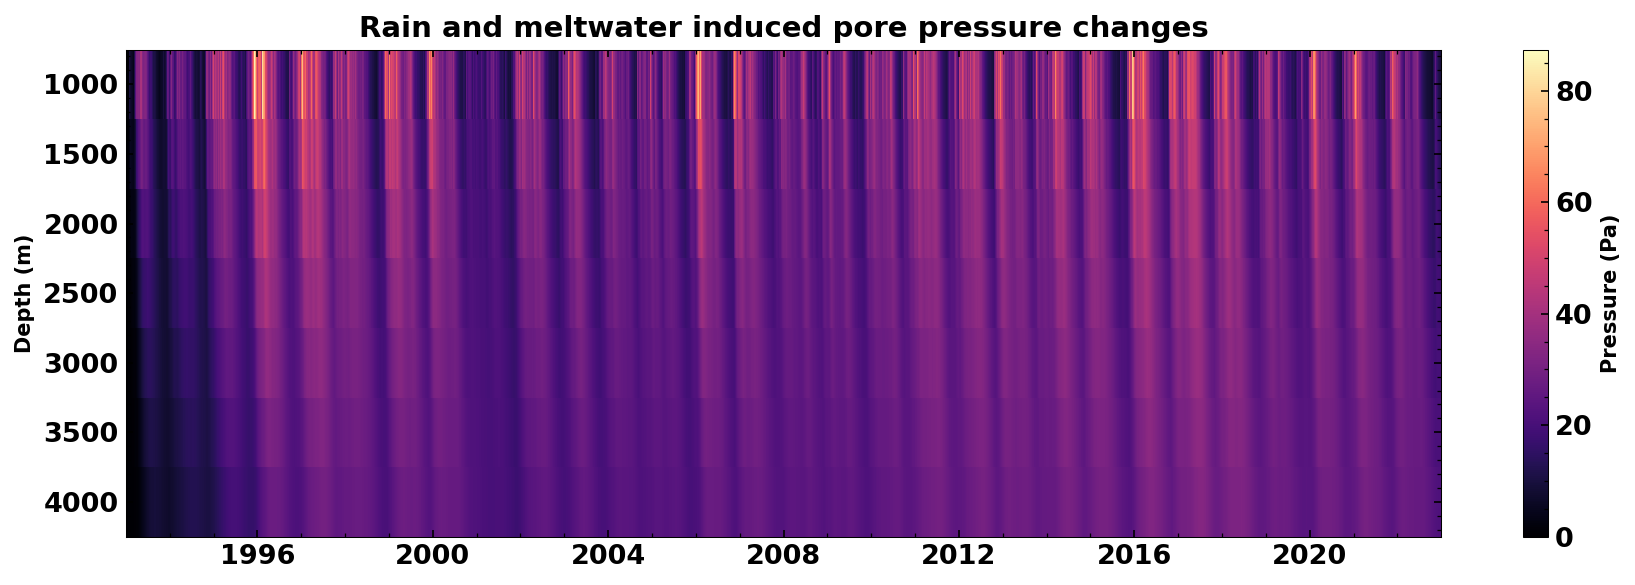

In [137]:
all = np.asarray([pluvio["P%i"%i] for i in depths])
all2 = np.asarray([pluvio["Pdiff2_%i"%i] for i in depths])
plt.figure(figsize=(12,4))
plt.pcolormesh(pluvio["date"], depths, all, cmap="magma")
cb = plt.colorbar()
cb.set_label("Pressure (Pa)")
plt.gca().invert_yaxis()
plt.title("Rain and meltwater induced pore pressure changes")
plt.ylabel("Depth (m)")
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())
plt.tight_layout()
plt.show()

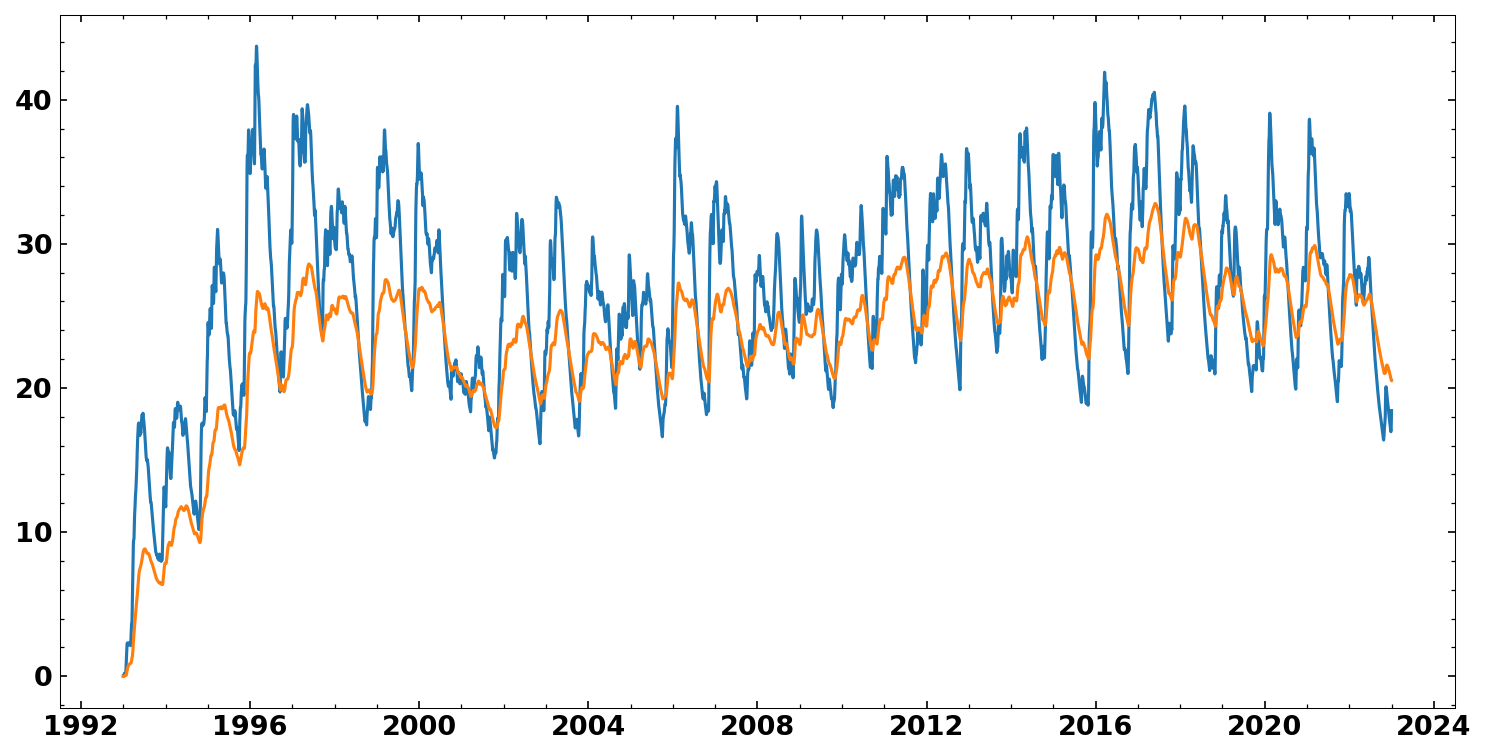

In [138]:
pluvio["P"] = all.mean(axis=0)
pluvio["Pdiff2_"] = all2.mean(axis=0)

plt.plot(pluvio['date'], pluvio["P"].values)
plt.plot(pluvio['date'], pluvio["Pdiff2_"].values)

plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())


In [139]:
# read dv
# from seismic.monitor.dv import read_dv
# dv = read_dv(f'../dv/resp_removed_longtw_final_QCpass/xstations_{freq}-{freq*2}_wl864000_*_srw/average.npz')[0]

# # let's filter a bit
# mask = np.all([dv.avail, dv.corr>.25], axis=0)
# corr_starts = np.array([tt.datetime for tt in dv.stats.corr_start])[mask]
# # Let's do a linear detrend because the long term trend is probably not climate related
# value = detrend(-1*dv.value[mask])

# df = pd.read_csv("results_2014_09_28/2019-inversion-ONTA_ONTA-100000.0.csv", index_col=0, parse_dates=True,names=["date", "M"])
# df = df.loc[pluvio.index[0]: pluvio.index[-1]].interpolate().ffill().bfill()
# df["M"] -= df["M"][0]
# df.tail()

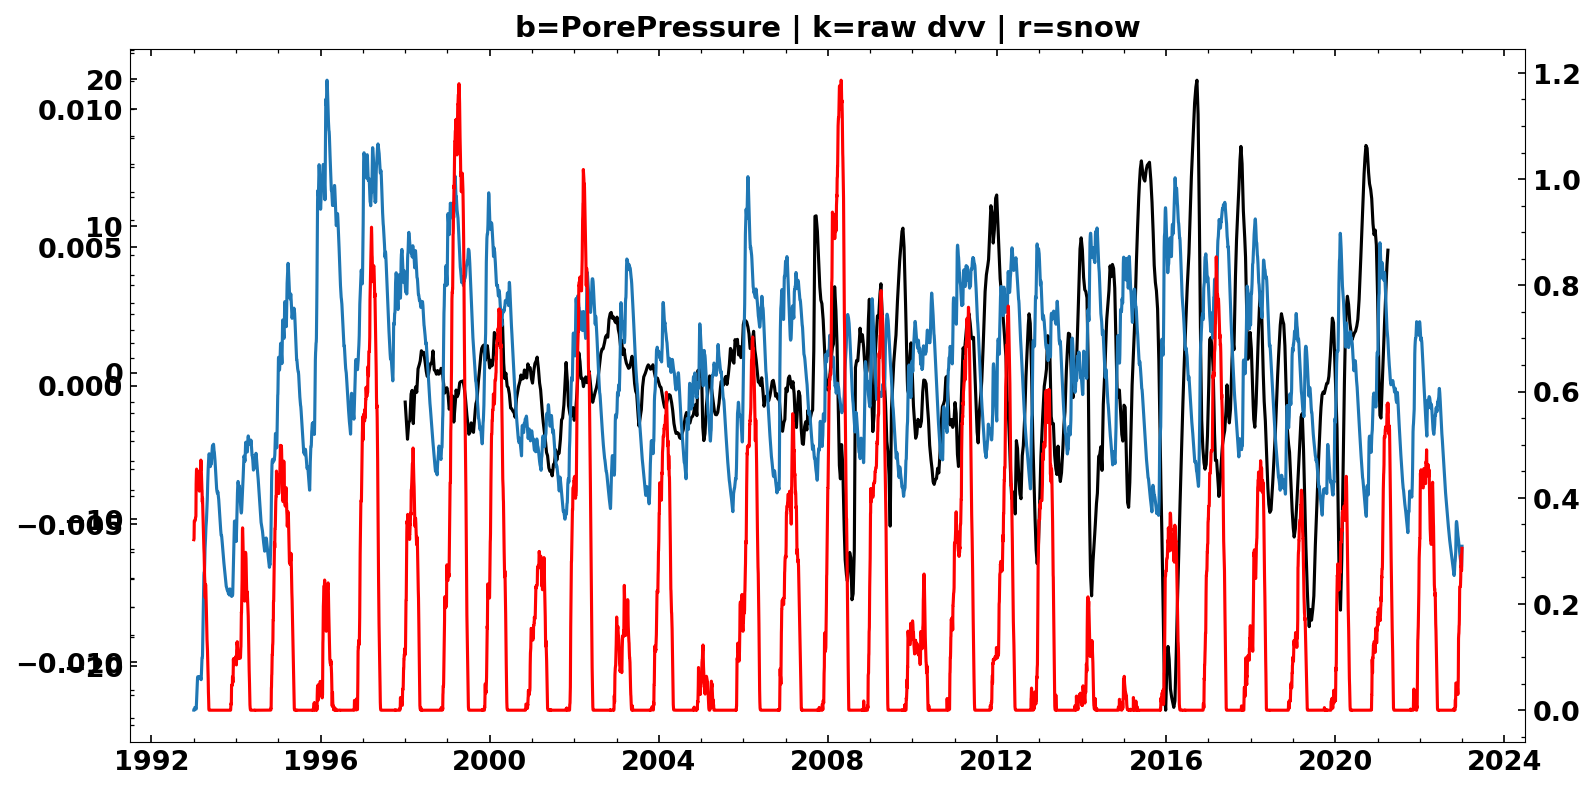

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [140]:
# pluvio = pluvio.loc["2013-01-01":]
pluvio["P"] = detrend(pluvio["P"])
pluvio["Pdiff2_"] = detrend(pluvio["Pdiff2_"])


plt.plot(np.array(pluvio['date'])[~np.isnan(pluvio['dv'])], np.array(pluvio["dv"])[~np.isnan(pluvio['dv'])], c='k')
plt.twinx()
plt.plot(list(pluvio['date']), list(pluvio["P"]))
plt.twinx()
plt.plot(pluvio['date'], pluvio["snow depth"], c='r')
plt.title("b=PorePressure | k=raw dvv | r=snow")
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())
plt.show()
plt.savefig

In [141]:
# from scipy.interpolate import interp1d
# from obspy import UTCDateTime

# x = [UTCDateTime(t).timestamp for t in corr_starts]
# xq = [UTCDateTime(t).timestamp for t in pluvio['date']]
# f = interp1d(x, value, bounds_error=False, fill_value=np.nan)
# val_intp = f(xq)

pluvio["dtt"] = -pluvio['dv']
pluvio["dtt"] = pluvio['dtt'].ffill()

### Computing Wang's Eq(3) to obtain the P(t) vs dv/v_obs ratio

We do that on a visually well matching slice of the data (but including the long term seasonal bump)

In [142]:
pluvio = pluvio.dropna()
# modelled dv/v
ii = np.all(["2017-6-01">pluvio['date'], pluvio['date']>"2011-01-01"], axis=0)
sliced = pluvio[["P", "Pdiff2_", "dtt", 'snow depth']].loc[ii].copy()
#sliced = pluvio[["P","dtt"]].loc["2013-03-01":"2013-06-01"].copy()
sliced["P"] = detrend(sliced["P"])
sliced["Pdiff2_"] = detrend(sliced["Pdiff2_"])
sliced["dtt"] = detrend(sliced["dtt"])


# try to fit the model for prior to 2008 as well, as the reaction to pore
# pressure changes seems to differ substantially
ii = np.all(["1999-01-01"<pluvio['date'], pluvio['date']<"2004-04-01"], axis=0)
sliced2 = pluvio[["P", "Pdiff2_", "dtt", 'snow depth']].loc[ii].copy()
#sliced = pluvio[["P","dtt"]].loc["2013-03-01":"2013-06-01"].copy()
sliced2["P"] = detrend(sliced2["P"])
sliced2["P"] = detrend(sliced2["Pdiff2_"])
sliced2["dtt"] = detrend(sliced2["dtt"])

ratio = np.cov(sliced["dtt"], sliced["P"])[1,0]/np.var(sliced["P"])
print(ratio)
predicted = sliced.dtt.mean() + ratio * (sliced["P"]-sliced["P"].mean())
print(1./ratio)

0.0006107359441561021
1637.368832747796


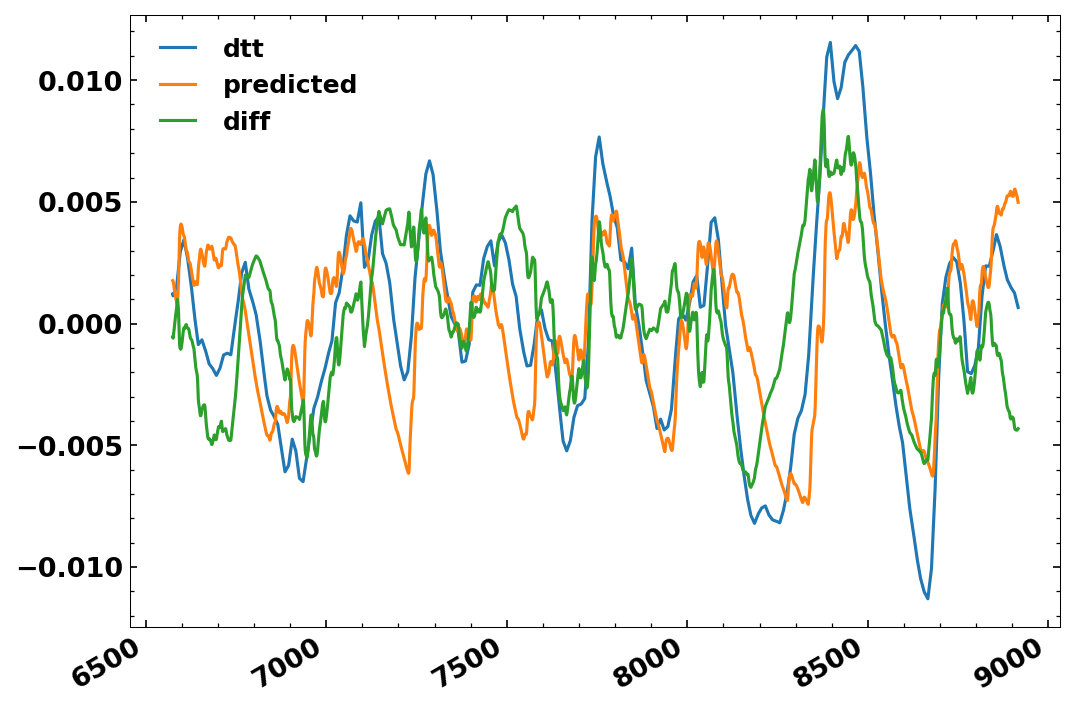

In [143]:
fig = plt.figure(figsize=(8,6))
plt.plot(sliced.index, sliced.dtt, label= 'dtt')
plt.plot(sliced.index, predicted, label ="predicted")
plt.plot(sliced.index, sliced.dtt - predicted, label='diff')
plt.legend()
fig.autofmt_xdate()
plt.show()

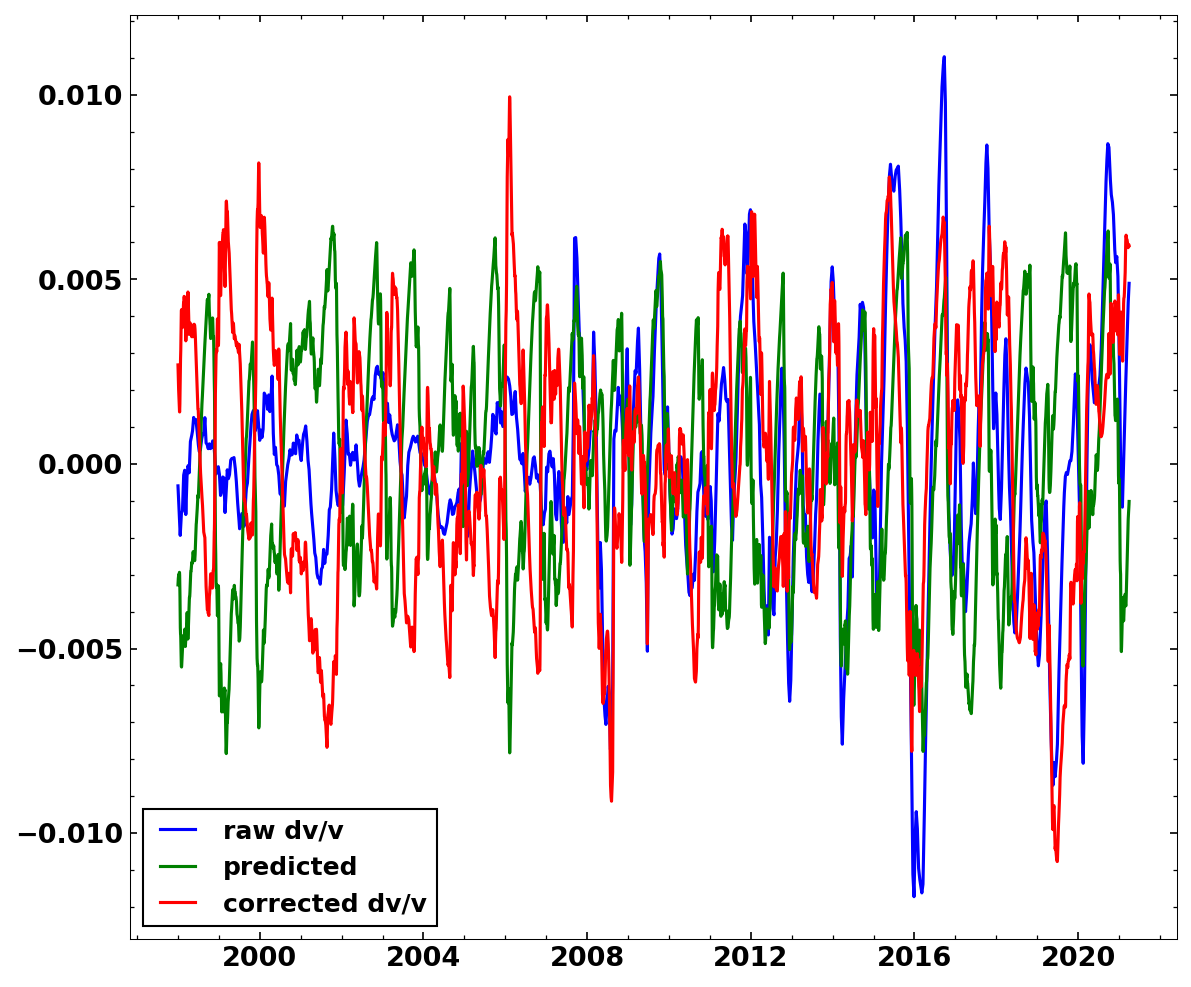

In [144]:
pluvio = pluvio.interpolate(method='ffill')
pluvio["P"] = detrend(pluvio["P"])
pluvio["dtt"] = pluvio["dtt"]
pluvio["predicted"] =  ratio * (pluvio["P"]-pluvio["P"].mean())

plt.figure(figsize=(9,8))
plt.plot(pluvio['date'], -1*pluvio["dtt"], c="b", label="raw dv/v")
plt.plot(pluvio['date'], -1*pluvio["predicted"], c="g", label="predicted")
plt.plot(pluvio['date'], -1*pluvio["dtt"] - (-1*pluvio["predicted"]), c="r", label="corrected dv/v")

# plt.plot(pluvio.index, -1*(pluvio["dtt (-dvv)"] - pluvio.P*factor*2),c="g", label="rain corrected dv/v")
plt.legend(loc=3, frameon=True)

#plt.xlim(datetime.datetime(2011,1,1),datetime.datetime(2018,1,1),)
plt.show()

## Define a,b mixing parameters manually

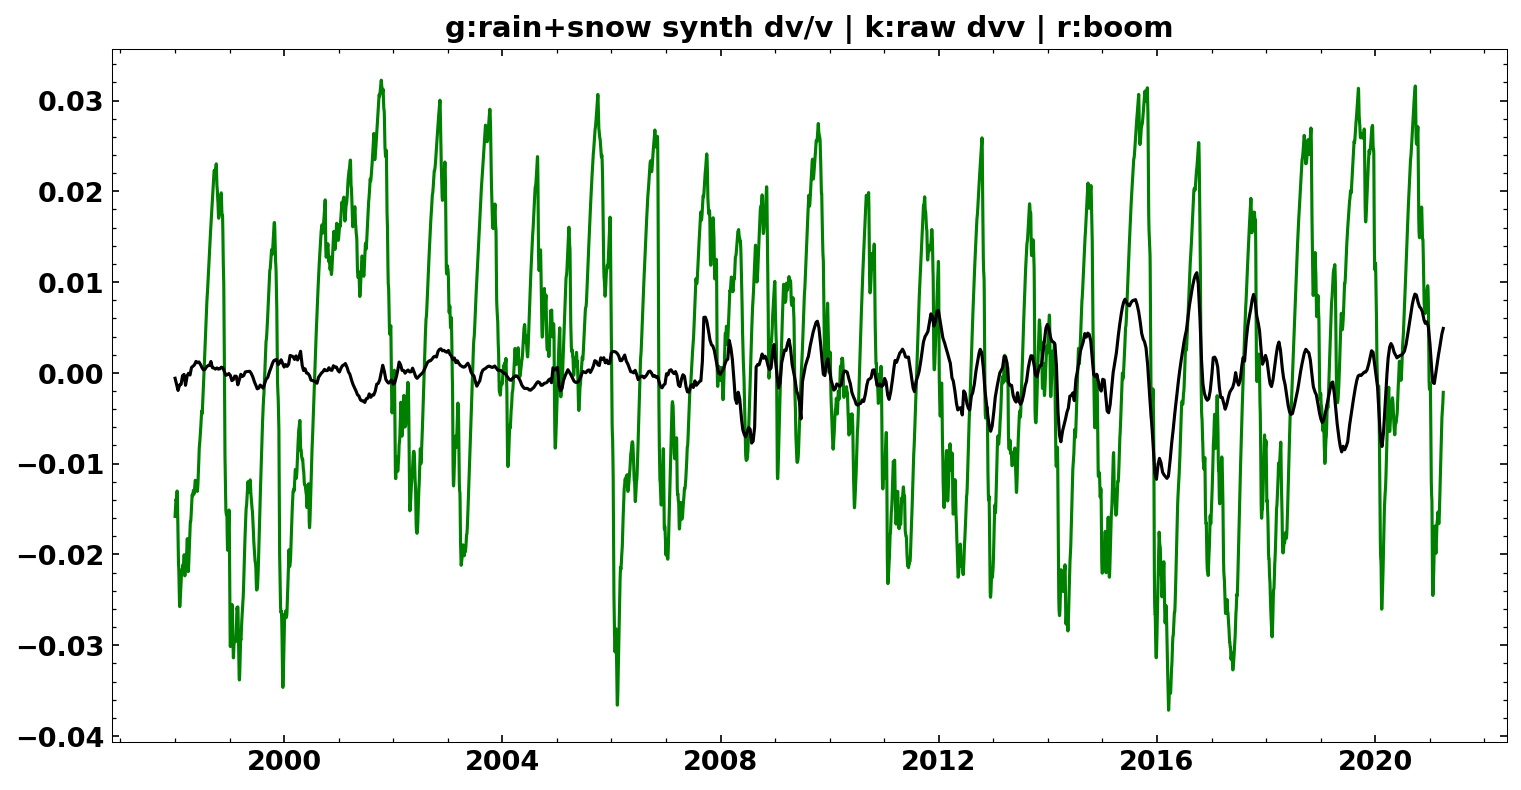

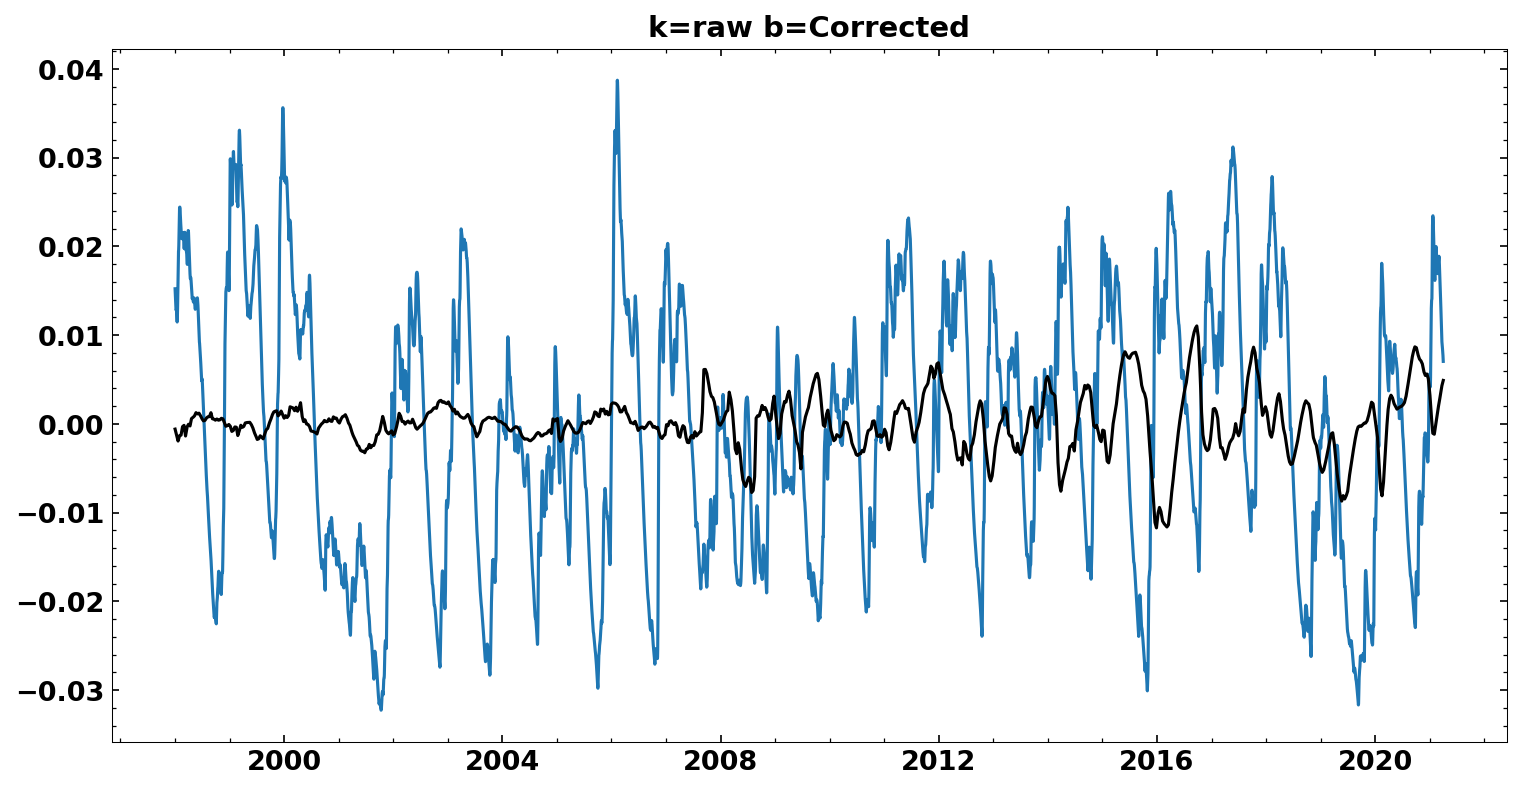

In [145]:
a = -5 #2 #because we work with the "Predicted" dv/v, which includes the ratio computed above
b = 5e-3 #-5e-3


dvv = pluvio['dv']
C = np.nanmean(dvv)

dvvsynth =  a * pluvio["predicted"] + b * pluvio["snow depth"] + C

plt.plot(pluvio['date'], dvvsynth , c="g", label="rain+snow synth dv/v")
# plt.twinx()
plt.plot(pluvio['date'], dvv , c="k", label="observed dv/v")
# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.show()


plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )






# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(pluvio['date'], dvv , c="k", label="observed dv/v")
plt.title("k=raw b=Corrected")
plt.show()


## Define a,b mixing parameters automatically by optimization

In this case, we don't have to define a "visually well matching time slice" of the data. All data are taken into account
in the optimization process.

In [146]:
from scipy.optimize import minimize

In [147]:
# pluvio["P"] -= pluvio["P"].mean()
# fun = lambda x: (((x[0] * pluvio["P"] + x[1] * pluvio["snow depth"]) - pluvio["dtt"])**2).sum()
# res = minimize(fun, [0.0, 0.0])
# print(res)
# a, b = res.x
# print(a, b)


sliced["P"] -= sliced["P"].mean()
sliced["Pdiff2_"] -= sliced["Pdiff2_"].mean()

fun = lambda x: (((x[0] * sliced["P"] + x[1] * sliced["snow depth"]) - sliced["dtt"])**2).sum()
res = minimize(fun, [0.0, 0.0])
print(res)
a, b = res.x


sliced2["P"] -= sliced2["P"].mean()
sliced2["Pdiff2_"] -= sliced2["Pdiff2_"].mean()


fun2 = lambda x: (((x[0] * sliced2["Pdiff2_"] + x[1] * sliced2["snow depth"]) - sliced2["dtt"])**2).sum()
res2 = minimize(fun2, [0.0, 0.0])
print(res2)
a2, b2 = res2.x

      fun: 0.023054488688534235
 hess_inv: array([[ 4.18615782e-04, -2.02701531e-02],
       [-2.02701531e-02,  9.99633232e-01]])
      jac: array([ 2.66171992e-06, -1.33691356e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([ 0.00064838, -0.0018722 ])
      fun: 0.0027370262544283257
 hess_inv: array([[ 0.00299122, -0.05442305],
       [-0.05442305,  1.00023299]])
      jac: array([ 8.02974682e-07, -6.72310125e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([-3.82926582e-05, -1.97705076e-04])


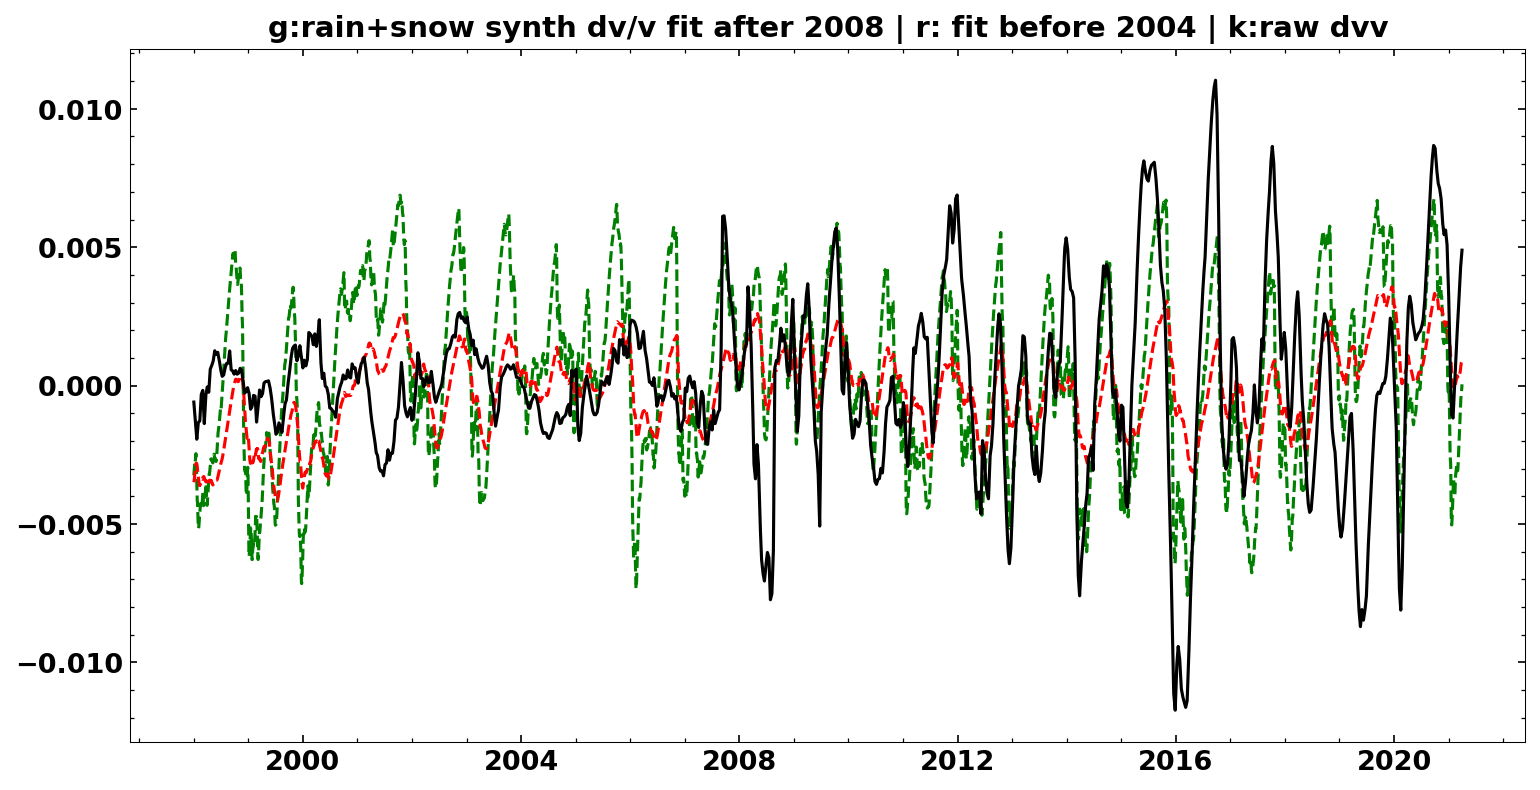

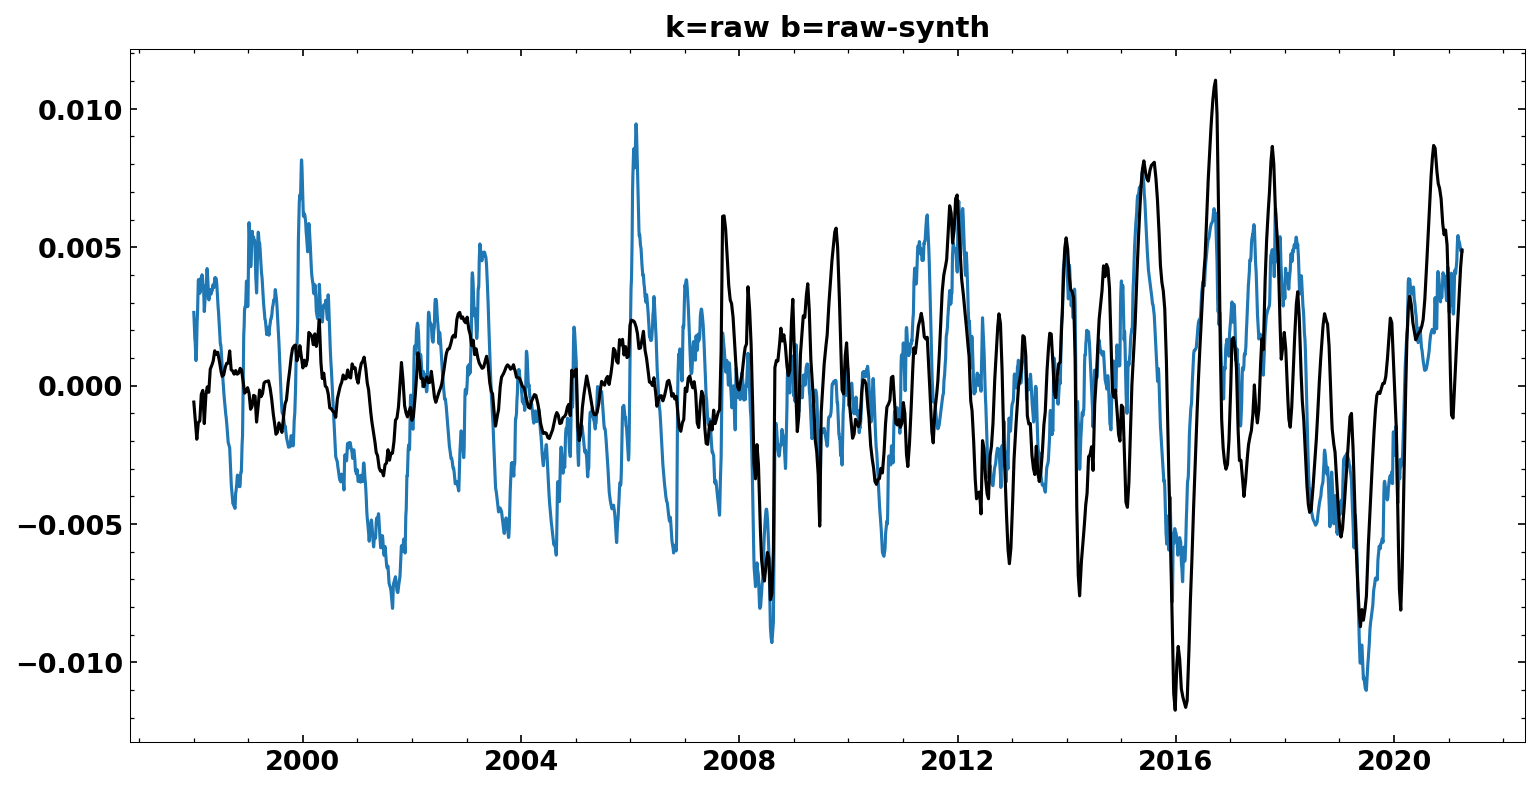

In [148]:
# dvv = df["M"]

# a2 = .0003
# b2 = -.004
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["snow depth"]) + C
# dvvsynth2 =  -1*(a2 * pluvio["P"] + b2 * pluvio["snow depth"]) + C
dvvsynth2 =  -1*(a * pluvio["Pdiff2_"] + b * pluvio["snow depth"]) + C


# dvv.to_csv('dvv_data.csv')
plt.plot(pluvio['date'], dvvsynth , c="g", linestyle='dashed', label="rain+snow synth dv/v after 2008")
plt.plot(pluvio['date'], dvvsynth2 , c="r", linestyle='dashed', label="rain+snow synth dv/v before 2008")

# plt.twinx()
plt.plot(pluvio['date'], dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v fit after 2008 | r: fit before 2004 | k:raw dvv")
# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )

plt.plot(pluvio['date'], dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")
plt.show()



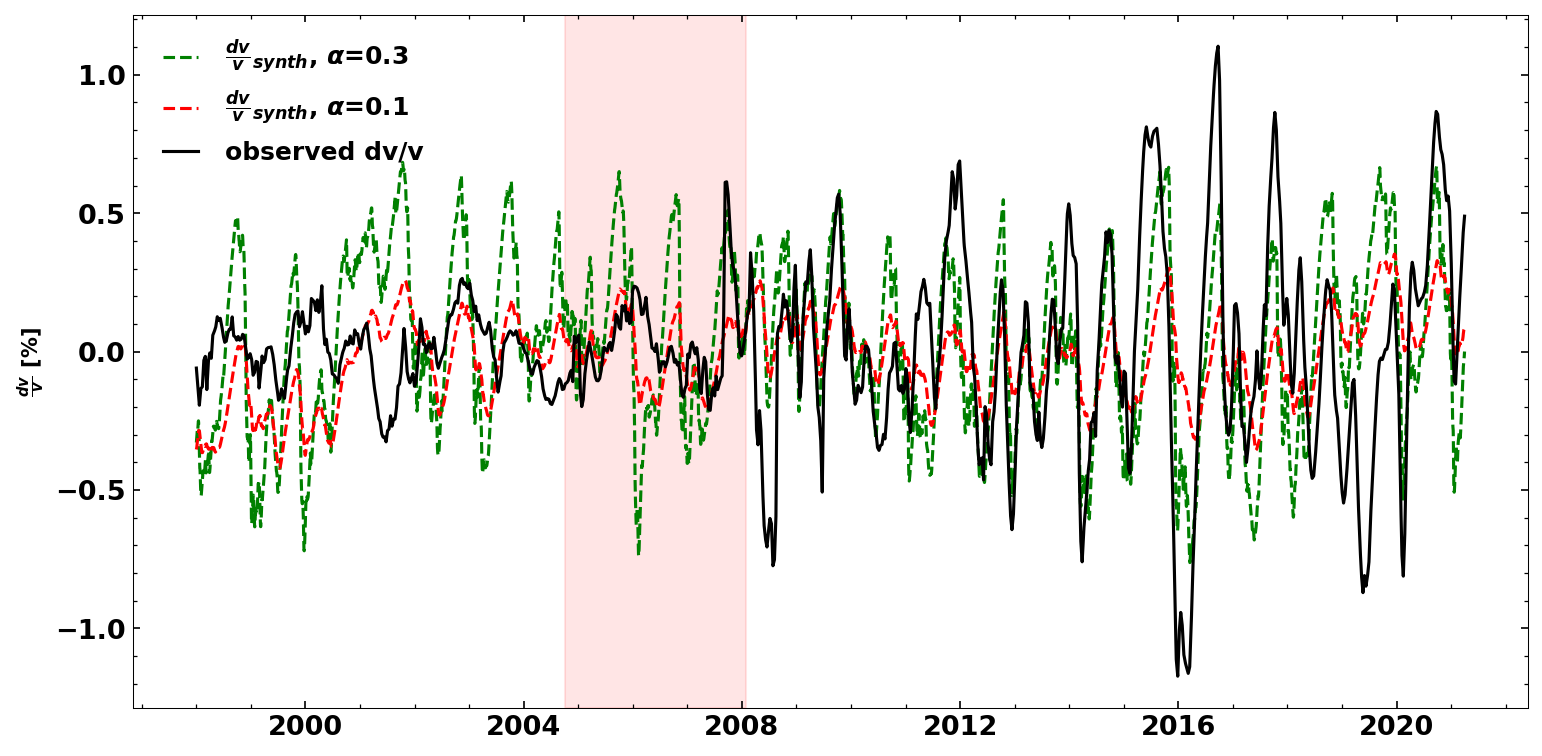

In [155]:
from seismic.plot.plot_utils import set_mpl_params
import os

set_mpl_params()

# Plot for EGU22 Poster
dvvsynth =  -100*(a * pluvio["P"] + b * pluvio["snow depth"]) + C
# dvvsynth2 =  -1*(a2 * pluvio["P"] + b2 * pluvio["snow depth"]) + C
dvvsynth2 =  -100*(a * pluvio["Pdiff2_"] + b * pluvio["snow depth"]) + C


# dvv.to_csv('dvv_data.csv')
plt.plot(pluvio['date'], dvvsynth , c="g", linestyle='dashed', label=r"$\frac{dv}{v}_{synth}$, $\alpha$="+str(alpha1))
plt.plot(pluvio['date'], dvvsynth2 , c="r", linestyle='dashed', label=r"$\frac{dv}{v}_{synth}$, $\alpha$="+str(alpha2))

# Colour plots background red between October 01 2004 and 31st January 2008
plt.axvspan(datetime.datetime(2004,10,1), datetime.datetime(2008,1,31), color='red', alpha=0.1, zorder=0)

# plt.twinx()
plt.plot(pluvio['date'], 100*dvv , c="k", label="observed dv/v")
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.legend()
os.makedirs('../EGU23/figures/', exist_ok=True)
plt.savefig('../EGU23/figures/pore_pressure_model.png', dpi=300, bbox_inches='tight', facecolor='none')
plt.savefig('../EGU23/figures/pore_pressure_model.pdf', bbox_inches='tight', facecolor='none')

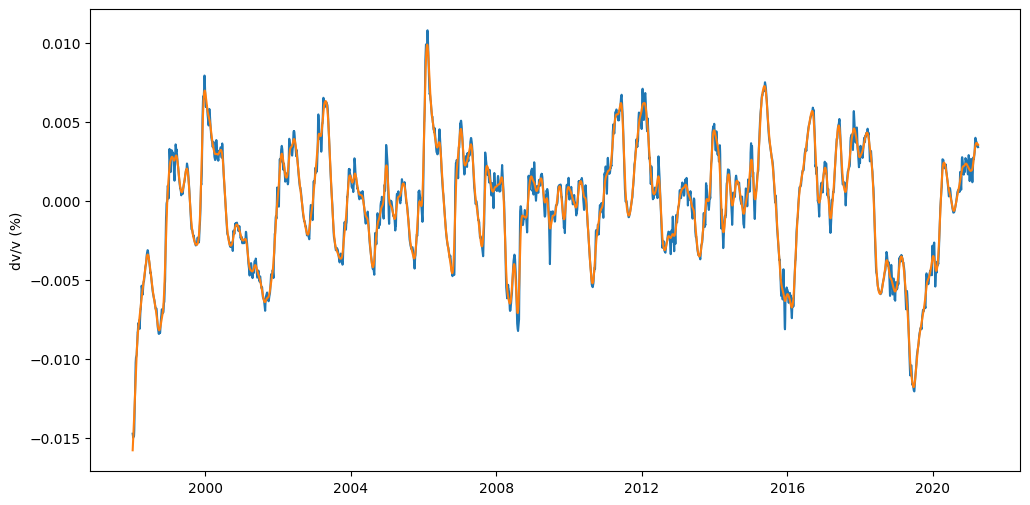

In [119]:
plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )
c,t = hpfilter(-pluvio['dtt']-dvvsynth, 10000)
plt.plot(pluvio['date'], t)
plt.ylabel("dv/v (%)")
plt.show()

# read events

In [120]:
def read_event_catalog(file, tz=0):
    names = ["Year","Month","Day","Hour","Minute","Second","Latitude","Longitude","Depth","Magnitude"]
    events = pd.read_csv(file, header=None, names=names, delim_whitespace=True)
    dt = [datetime.datetime(2000+int(r["Year"]),int(r["Month"]),int(r["Day"]),int(r["Hour"]),int(r["Minute"]))+datetime.timedelta(r["Second"]) for id, r in events.iterrows()]
    if tz != 0:
        dt = [d-datetime.timedelta(hours=tz) for d in dt]
    events.index = pd.DatetimeIndex(dt)
    for _ in ["Year","Month","Day","Hour","Minute","Second"]:
        del events[_]
    events = events.sort_index()
    return events

In [121]:
VT = read_event_catalog("ontake_hypo.MAD100", tz=9)
LP = read_event_catalog("ontake_hypoLP.MAD130", tz=9)

FileNotFoundError: [Errno 2] No such file or directory: 'ontake_hypo.MAD100'

<IPython.core.display.Javascript object>


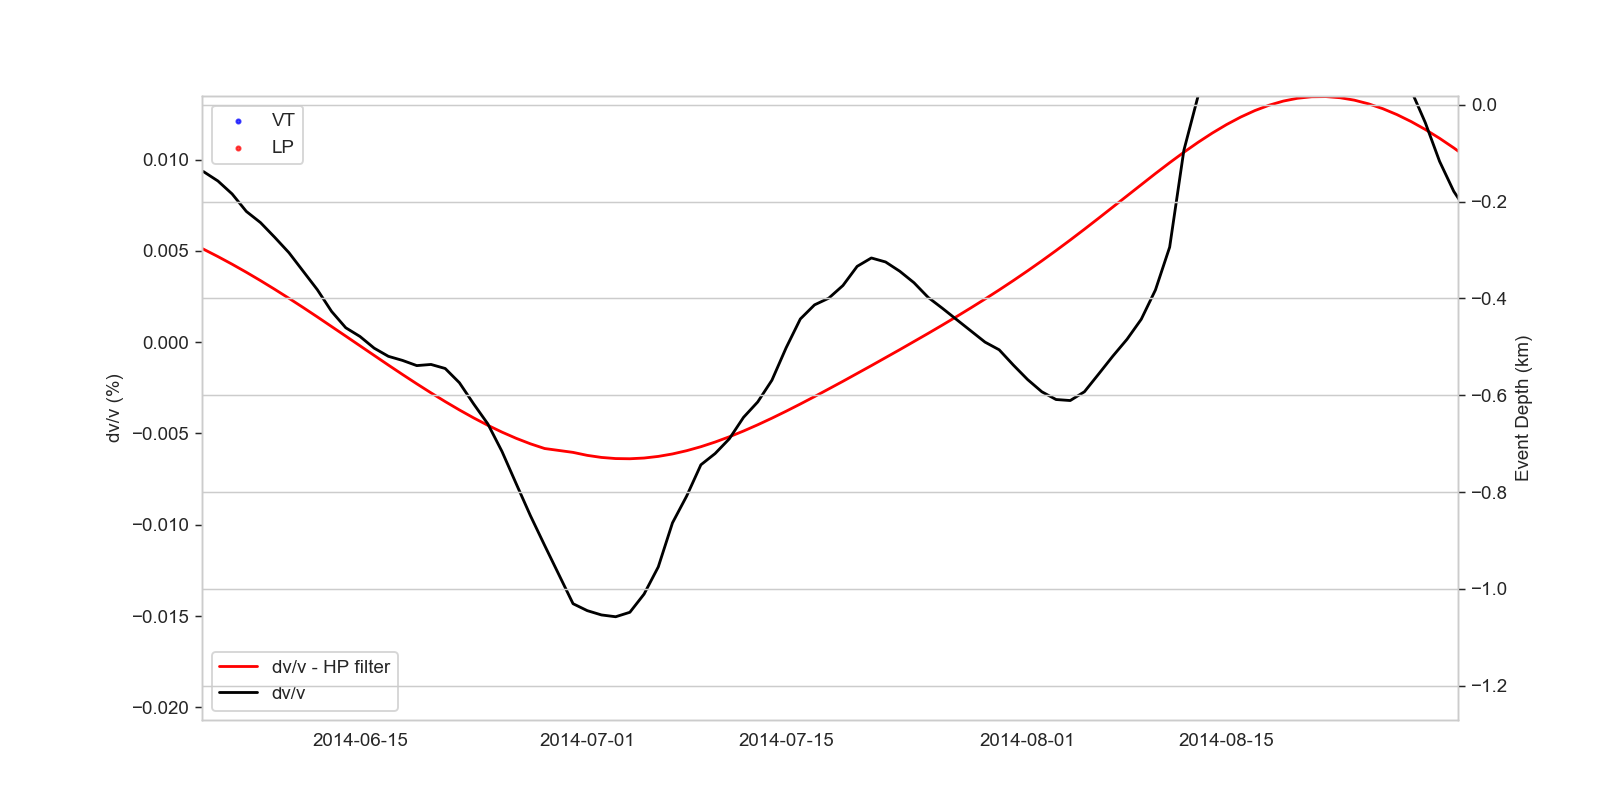

In [ ]:
plt.plot(pluvio.index, t, label="dv/v - HP filter", c='r')
plt.plot(pluvio.index, dvv-dvvsynth, label="dv/v", c='k' )
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.grid(False)
plt.ylabel("dv/v (%)")
plt.legend(loc=3)
plt.twinx()
plt.scatter(VT.index, VT["Depth"], label="VT", s=5,alpha = 0.7,c='b')
plt.scatter(LP.index, LP["Depth"], c='r', label="LP",s=5,alpha = 0.7)
plt.legend(loc=3)
plt.ylabel("Event Depth (km)")


plt.legend(loc=2)
plt.savefig('Fig4.pdf',dpi=300)
plt.show()

In [ ]:
VT["type"] = "VT"
LP["type"] = "LP"
events= pd.concat((VT,LP))
print(events.head())

In [ ]:
events.to_csv("ListEvents_WithCat.csv")

In [ ]:
VT.index

In [ ]:
dvv = df["M"]
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["Snow depth (cm)"])


plt.plot(pluvio.index, dvvsynth , c="g", label="rain+snow synth dv/v")
plt.twinx()
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio.index, dvv-dvvsynth )

plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")


ax=plt.twinx()
detec = pd.read_csv(r'C:\Users\caudroco\Documents\Ontake\Nov_2019\template_matching\detections_per_12h.csv',index_col=0, header=0, parse_dates=True)
ax.plot(detec.index,detec.detect_val,c='k')


plt.show()





In [ ]:
### stress transfer

# m/s
vel = 10e-3
# 36 km between 
distance = 36000

time = (distance/vel)/(3600*24)
print(time)

41.666666666666664


In [ ]:
# m/s
time = (3600*24*30)
# 36 km between 
distance = 36000

vel = (distance/time)
print(vel)

0.013888888888888888
